In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score
from sklearn import mixture, preprocessing, datasets

from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches

import torch.utils.data as data_utils

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

import model_paths

This notebook finds the best attack samples for a given dataset, using the statistics collecting in **gen_attack_stats.py**. In the file_dict below one has to specify the path name of the saved results, one wishes to select from.
The output is a sample for each model in **model_paths.py**. All samples in a row are generated from the same seed.

In [4]:
dataset = 'MNIST'

file_dict = {'MNIST' :'samples_steps500_alpha3.0_restarts50_batches2_batch_size100_MNIST_2019-09-12 22:24:19.521988_MNIST.pth',
             'FMNIST':'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_FMNIST_2019-06-11 08:05:12.188177_FMNIST.pth',
             'SVHN' : 'gmm__PCASVHN_lam0.0_n100_lr0.1_lrgmm1e-05_augm_flagTrue_train_typeCEDA_GMM_OUTgrad_vars mu var_OUT.pth',
             'CIFAR10':'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_CIFAR10_2019-06-15 06:40:05.851630_CIFAR10.pth',
             'CIFAR100' : 'samples_steps200_alpha3.0_restarts10_batches10_batch_size100_CIFAR100_2019-06-15 06:41:07.390466_CIFAR100.pth'
            }

file = file_dict[dataset]
#file = 'samples_steps500_alpha3.0_restarts50_batches2_batch_size50_CIFAR10_2019-09-10 20:28:05.336957_CIFAR10.pth'

batch = torch.load('results/backup/' + file)

model_params = params.params_dict[dataset]()
model_path = model_paths.model_dict[dataset]() 
model_list = [torch.load(file).cpu().eval() for file in list(model_path.file_dict.values())][:-1]

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'utils.models.PCAMetric' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [5]:
num_of_models = len(model_list)

num = batch.samples.shape[0]*batch.samples.shape[2]

if dataset in ['MNIST', 'FMNIST']:
    noise = batch.samples.transpose(0,1).contiguous().view(num_of_models, num, 1, 28, 28)
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    noise = batch.samples.transpose(0,1).contiguous().view(num_of_models, num, 3, 32, 32)
    
noise_list = []
for i in range(num_of_models):
    noise_list.append(noise[i])

RuntimeError: shape '[8, 200, 1, 28, 28]' is invalid for input of size 1411200

In [8]:
Y = [model(no).max(1) for (no, model) in zip(noise_list, model_list)]
conf = [y[0][0].exp().item() for y in Y]
pred = [y[1][0].item() for y in Y]

In [9]:
conf = torch.stack([y[0] for y in Y], 0)
index = conf.exp().sum(0).argmax()
#index = 10

if dataset in ['MNIST', 'FMNIST']:
    seed = batch.seeds.view(-1,1,28,28)[index]
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    seed = batch.seeds.view(-1,3,32,32)[index]

adv_noise = noise[:,index]

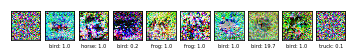

In [10]:
model_names = list(model_path.file_dict.keys())[:-1]

plt.subplot(1, num_of_models+1, 1)
#plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
#          fontsize=14, position=(0,0))

if dataset in ['MNIST', 'FMNIST']:
    plt.imshow(seed.squeeze().detach().cpu(), cmap='gray', interpolation='none')
elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
    plt.imshow(seed.transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')

plt.xticks([])
plt.yticks([])

for i in range(num_of_models):
    plt.subplot(1, num_of_models + 1, 2 + i)
    #if i==0:
        #plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
        #           fontsize=14, position=(0,0))
        
    if dataset in ['MNIST', 'SVHN']:
        string = model_names[i] + '\n'
    else:
        string = ''

    subtitle_string = ( str(plotting.classes_dict[dataset][pred[i]] )
                       + ": %.1f" % conf[i][index].exp().item() )
    
    title_string = model_names[i]
    
    if dataset=='MNIST':
        plt.title(title_string, fontsize=7)
    #plt.title(string)
    plt.xlabel(subtitle_string, fontsize=5)

    if dataset in ['MNIST', 'FMNIST']:
        plt.imshow(adv_noise[i].squeeze().detach().cpu(), cmap='gray', interpolation='none')
    elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
        plt.imshow(adv_noise[i].transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.16, hspace=None)
myplot = plt.gcf()

In [30]:
myplot.savefig('results/' + dataset + '_sample_all_models' + '.eps', format='eps', 
               bbox_inches = 'tight', pad_inches = .01)

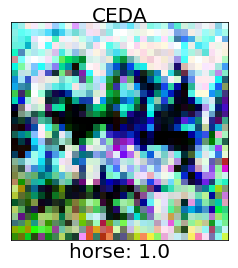

In [132]:
model_names = list(model_path.file_dict.keys())

fontsize = 20
pad = 1
model_order = [0, 1, 3, 6, 4, 2, 8, 5, 7]

model_order = [1]
num_of_models = len(model_order)

if num_of_models==0:

    plt.subplot(1, 1, 1)
    plt.title('Seed', fontsize=fontsize, pad=pad)
    #plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
    #          fontsize=14, position=(0,0))

    if dataset in ['MNIST', 'FMNIST']:
        plt.imshow(seed.squeeze().detach().cpu(), cmap='gray', interpolation='none')
    elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
        plt.imshow(seed.transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')

    plt.xticks([])
    plt.yticks([])

for i, j in zip(model_order, range(num_of_models)):
    
    plt.subplot(1, num_of_models, 1 + j)
    #if i==0:
        #plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
        #           fontsize=14, position=(0,0))
        
    if dataset in ['MNIST', 'SVHN']:
        string = model_names[i] + '\n'
    else:
        string = ''

    string += ( str(plotting.classes_dict[dataset][pred[i]] )
               + ": %.1f" % conf[i][index].exp().item() )
    string = string if j<7 else (j-6)*'*'
    if model_names[i] == 'CCUU':
        string = (str(plotting.classes_dict[dataset][pred[i]] )
               + ": "  + r"$\bf{" + "%.1f" % conf[i][index].exp().item()  + "}$" )
    
    string2 = model_names[i] 
    
    plt.title(string2, fontsize=fontsize, pad=pad)
    plt.xlabel(string, fontsize=fontsize, labelpad=2)

    if dataset in ['MNIST', 'FMNIST']:
        plt.imshow(adv_noise[i].squeeze().detach().cpu(), cmap='gray', interpolation='none')
    elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
        plt.imshow(adv_noise[i].transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')
    plt.xticks([])
    plt.yticks([])
    
    
# plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.12, hspace=.2)
myplot = plt.gcf()

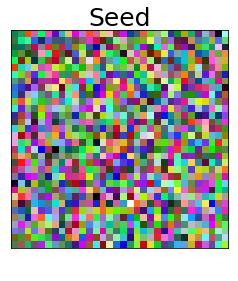

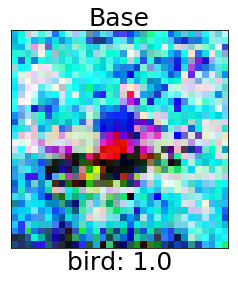

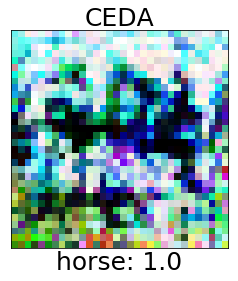

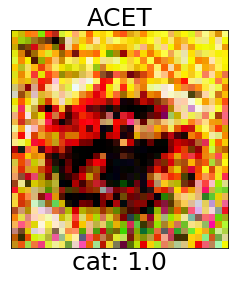

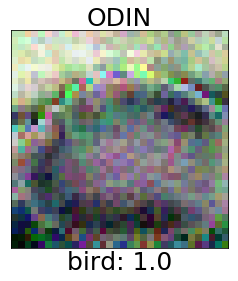

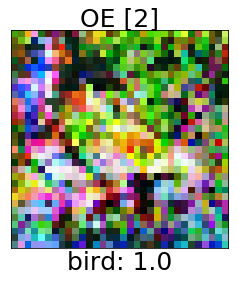

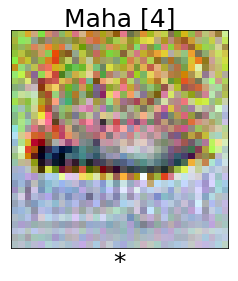

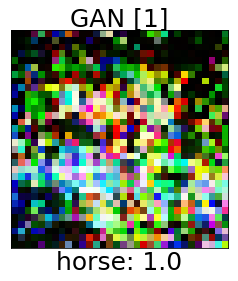

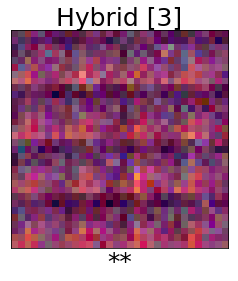

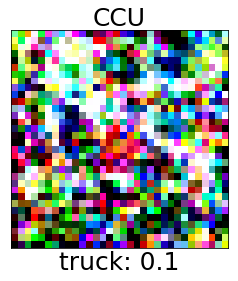

In [187]:
model_names = list(model_path.file_dict.keys())
model_names = ['Base', 'CEDA', 'ACET', 'ODIN', 'OE [2]', 'Maha [4]', 'GAN [1]', 'Hybrid [3]', 'CCU']

fontsize = 25
pad = 5
model_order = [0, 1, 3, 6, 4, 2, 8, 5, 7]

master_list = [[]] + [[x] for x in list(range(9))]

for model_order in master_list:
    num_of_models = len(model_order)

    if num_of_models==0:

        plt.subplot(1, 1, 1)
        plt.title('Seed', fontsize=fontsize, pad=pad)
        #plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
        #          fontsize=14, position=(0,0))

        if dataset in ['MNIST', 'FMNIST']:
            plt.imshow(seed.squeeze().detach().cpu(), cmap='gray', interpolation='none')
        elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
            plt.imshow(seed.transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')

        plt.xlabel('.', fontsize=fontsize, labelpad=2, color='white')
        plt.xticks([])
        plt.yticks([])

    for i, j in zip(model_order, range(num_of_models)):

        plt.subplot(1, num_of_models, 1 + j)
        #if i==0:
            #plt.ylabel(' ' + dataset + '\n', rotation=90, horizontalalignment='left', va='center',
            #           fontsize=14, position=(0,0))

        if dataset in ['MNIST', 'SVHN']:
            string = model_names[i] + '\n'
        else:
            string = ''

        string += ( str(plotting.classes_dict[dataset][pred[i]] )
                   + ": %.1f" % conf[i][index].exp().item() )
        string = string if j<7 else (j-6)*'*'
        if model_names[i] == 'CCUU':
            string = (str(plotting.classes_dict[dataset][pred[i]] )
                   + ": "  + r"$\bf{" + "%.1f" % conf[i][index].exp().item()  + "}$" )
        if model_names[i] == 'Maha [4]':
            string = '*'
        if model_names[i] == 'Hybrid [3]':
            string = '**'

        string2 = model_names[i] 

        plt.title(string2, fontsize=fontsize, pad=pad)
        
        plt.xlabel(string, fontsize=fontsize, labelpad=2, color='black')

        if dataset in ['MNIST', 'FMNIST']:
            plt.imshow(adv_noise[i].squeeze().detach().cpu(), cmap='gray', interpolation='none')
        elif dataset in ['CIFAR10', 'SVHN', 'CIFAR100']:
            plt.imshow(adv_noise[i].transpose(0,2).transpose(0,1).detach().cpu(), interpolation='none')
        plt.xticks([])
        plt.yticks([])


    # plt.tight_layout()
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.12, hspace=.2)
    myplot = plt.gcf()

    name = model_names[model_order[0]] if num_of_models==1 else 'seed'
    myplot.savefig('results/Samples/' + name + '.eps', format='eps', 
                   bbox_inches = 'tight', pad_inches = .01)
    plt.show()

In [152]:
name = model_names[model_order[0]] if num_of_models==1 else 'seed'
myplot.savefig('results/Samples/' + name + '_sample_all_models' + '.eps', format='eps', 
               bbox_inches = 'tight', pad_inches = .01)

In [87]:
model_list[5](adv_noise[5].unsqueeze(0)).max()

tensor(-0.0001, grad_fn=<MaxBackward1>)

In [93]:
x = next(iter(in_loader))[0].to(device)

In [110]:
in_loader = dl.CIFAR10(train=True, augm_flag=False)

In [91]:
device = torch.device('cuda:7')

In [112]:
model = model_list[5].to(device)

In [98]:
model(x).max()

tensor(-0.4943, device='cuda:7', grad_fn=<MaxBackward1>)

In [113]:
log_p = -30000

for data, _ in in_loader:
    data = data.to(device)
    temp = model(data).max().item()
    if temp > log_p:
        log_p = temp
        print(temp)
print(log_p)

-0.2220010757446289
-0.221954345703125
-0.10101190209388733
-0.09885716438293457
-0.09397575259208679
-0.07717470824718475
-0.07717470824718475


In [117]:
import matplotlib.gridspec as gridspec

In [162]:
model_names = ['Base', 'CEDA', 'ACET', 'ODIN', 'OE [2]', 'Maha [4]', 'GAN [1]', 'Hybrid [3]', 'CCU']

In [189]:
adv_noise.shape

torch.Size([9, 3, 32, 32])

In [191]:
seed

tensor([[[3.3834e-02, 1.7026e-01, 9.6066e-01,  ..., 6.3534e-01,
          6.2684e-02, 6.2171e-01],
         [2.3686e-01, 4.3612e-02, 3.0501e-01,  ..., 6.3756e-01,
          3.4585e-01, 4.0223e-01],
         [7.1797e-02, 3.6765e-02, 3.2140e-01,  ..., 9.3967e-02,
          9.6777e-01, 1.3797e-01],
         ...,
         [4.9390e-01, 4.4632e-01, 7.1050e-01,  ..., 2.7926e-01,
          6.2999e-01, 5.4344e-01],
         [4.4344e-01, 2.8731e-01, 7.4252e-01,  ..., 8.1448e-01,
          2.9785e-01, 7.2826e-01],
         [2.8864e-01, 5.7778e-01, 1.1322e-01,  ..., 3.7354e-01,
          2.7814e-01, 6.1636e-01]],

        [[5.0953e-01, 6.1625e-01, 3.2498e-01,  ..., 3.6612e-01,
          2.2474e-02, 9.8625e-01],
         [4.6046e-01, 9.1845e-01, 9.3817e-01,  ..., 7.0021e-01,
          4.1866e-01, 8.4726e-01],
         [4.3986e-01, 4.3336e-01, 4.5456e-01,  ..., 5.8789e-01,
          7.4295e-01, 1.2280e-01],
         ...,
         [4.6447e-01, 4.5191e-01, 9.0255e-01,  ..., 6.5894e-01,
          9.334

In [200]:
model_list[-1].mm.metric(seed.view(1, 1, -1), adv_noise.view(9, 1, -1))

tensor([[8.2635],
        [8.2635],
        [8.2639],
        [8.2541],
        [8.2299],
        [8.2573],
        [8.2010],
        [8.2733],
        [8.2167]])

In [195]:
seed.shape

torch.Size([3, 32, 32])

In [197]:
adv_noise.shape

torch.Size([9, 3, 32, 32])

In [ ]:
torch.rand(10)